# CP

## Imports

In [55]:
#!pip install pycaret

## Modelo 1 - REAL

In [56]:
nltk.download('stopwords')
from transformers                     import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from yellowbrick.cluster              import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing            import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics                  import silhouette_score
from sklearn.cluster                  import KMeans
from pycaret.clustering               import *
from nltk.corpus                      import stopwords

import matplotlib.pyplot  as plt
import seaborn            as sns
import pandas             as pd
import numpy              as np
import torch
import joblib
import nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Analise exploratoria

In [57]:
df = pd.read_csv('all_movies.csv', sep=';')
print("Dimensões do dataset:", df.shape)
print("Colunas do dataset:", df.columns)

Dimensões do dataset: (250, 6)
Colunas do dataset: Index(['title_pt', 'title_en', 'year', 'rating', 'genre', 'sinopse'], dtype='object')


In [58]:
# Estatísticas descritivas
print(df.describe())

              year      rating
count   250.000000  250.000000
mean   1986.684000    8.302800
std      25.508171    0.239545
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.200000
75%    2007.000000    8.400000
max    2023.000000    9.300000


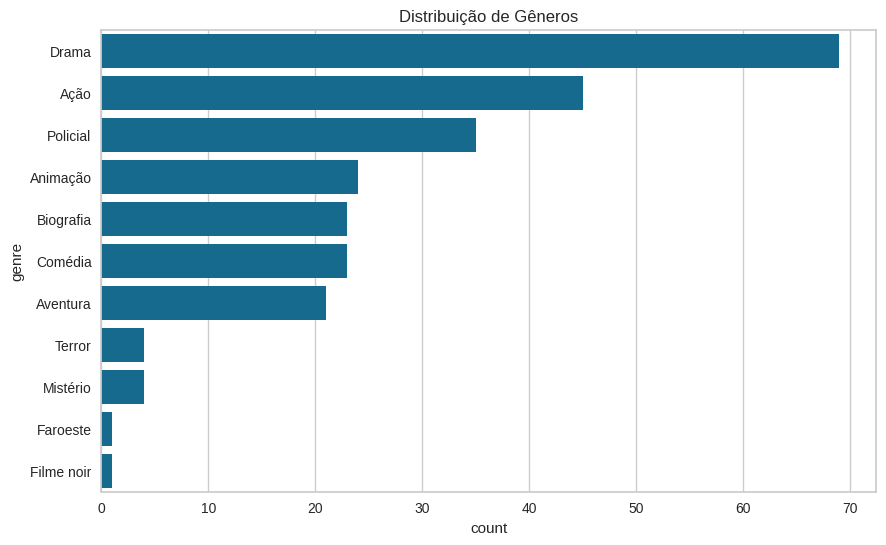

In [59]:
# Visualização da distribuição de gêneros
plt.figure(figsize=(10,6))
sns.countplot(y=df['genre'], order=df['genre'].value_counts().index)
plt.title("Distribuição de Gêneros")
plt.show()

### Tratamento dos dados

In [60]:
# Removendo valores nulos
df.dropna(inplace=True)

# Removendo Stopwords das sinopses
df['sinopse_clean'] = df['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in set(stopwords.words('portuguese'))]))

In [61]:
# Encoding para os títulos
encoder = LabelEncoder()
df['title_pt_encoded'] = encoder.fit_transform(df['title_pt'])

In [62]:
# Tokenização com BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

### Modelo 3 - SKLearn + BERT

In [63]:
def fine_tune_bert(texts, labels):
    model.train()
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Exemplo de treinamento sem o argumento 'labels'
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)  # Sem labels
        loss = outputs.last_hidden_state.mean()  # Usando uma métrica de exemplo para cálculo de perda
        loss.backward()
        optimizer.step()
    return model

In [64]:
# Fine-tuning com algumas sinopses como exemplo (processo pode ser mais longo)
texts = df['sinopse_clean'].values[:100]
labels = np.random.randint(0, 3, size=(100,))  # Apenas para fins de exemplo
fine_tune_bert(texts, labels)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [65]:
# Vetorizando as sinopses com BERT após fine-tuning
def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()  # Tirando a média da última camada oculta para cada frase

embeddings = np.vstack([embed_text(text) for text in df['sinopse_clean']])

### Modelo

In [66]:
# Modelo de cluster usando KMeans do SKLearn
kmeans = KMeans()

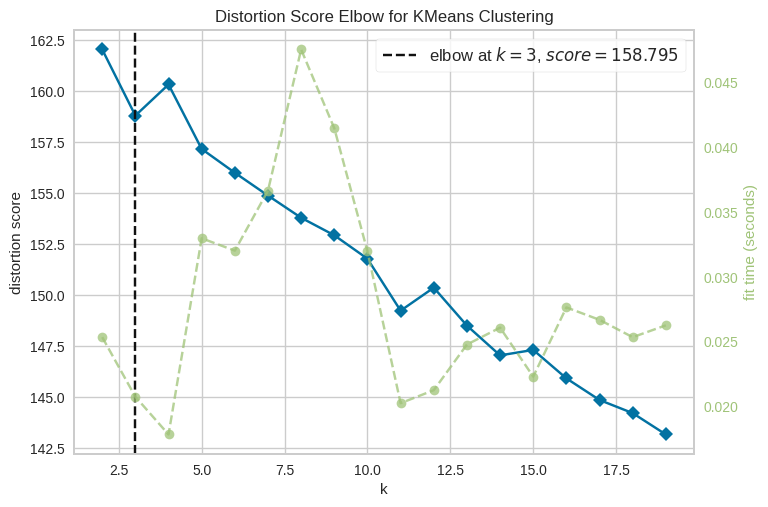

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
# KElbowVisualizer para encontrar o número ideal de clusters
visualizer = KElbowVisualizer(kmeans, k=(2,20))
visualizer.fit(embeddings)
visualizer.show()

In [68]:
# Ajustando o KMeans com o número ideal de clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, init='k-means++', max_iter=500, n_init=50)
clusters = kmeans.fit_predict(embeddings)

joblib.dump(kmeans, 'kmeans_model_2.0.joblib')

['kmeans_model_2.0.joblib']

### Avaliação

In [69]:
# Atribuindo os clusters ao DataFrame
df['Cluster'] = clusters

# Salvando o DataFrame atualizado com a coluna 'Cluster'
df.to_csv('all_movies_with_clusters.csv', sep=';', index=False)

In [70]:
# Exibindo os primeiros 5 resultados com seus clusters
df.head()

,title_pt,title_en,year,rating,genre,sinopse,sinopse_clean,title_pt_encoded,Cluster
0,Barbie,Barbie,2023,7.4,Aventura,Viver na Terra da Barbie é ser um ser perfeito...,Viver Terra Barbie perfeito lugar perfeito. A ...,39,2
1,Um Sonho de Liberdade,1. The Shawshank Redemption,1994,9.3,Drama,Dois homens presos se reúnem ao longo de vário...,"Dois homens presos reúnem longo vários anos, e...",236,2
2,O Poderoso Chefão,2. The Godfather,1972,9.2,Policial,O patriarca idoso de uma dinastia do crime org...,O patriarca idoso dinastia crime organizado tr...,157,1
3,Batman: O Cavaleiro das Trevas,3. The Dark Knight,2008,9.0,Ação,Quando a ameaça conhecida como O Coringa surge...,Quando ameaça conhecida O Coringa surge passad...,43,1
4,O Poderoso Chefão II,4. The Godfather Part II,1974,9.0,Policial,"Em 1950, Michael Corleone, agora à frente da f...","Em 1950, Michael Corleone, agora frente famíli...",158,2


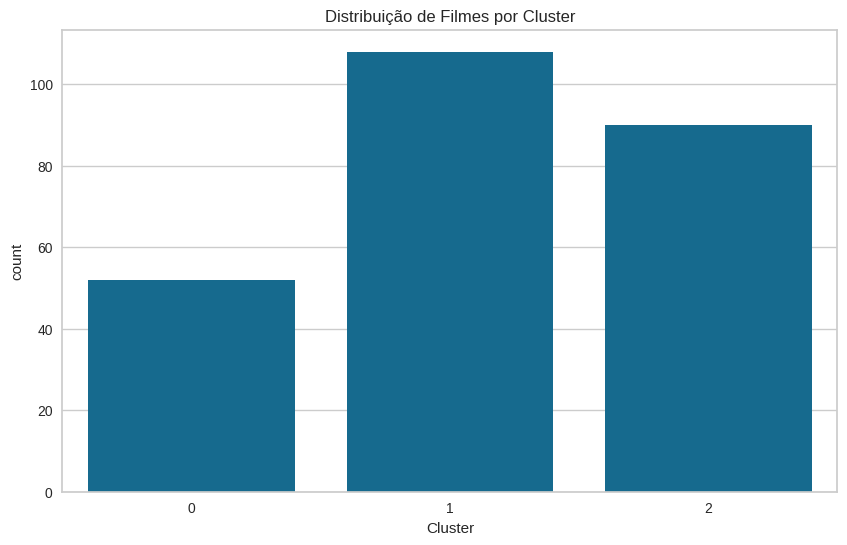

In [71]:
# Visualização dos clusters - Contagem de filmes por cluster
plt.figure(figsize=(10,6))
sns.countplot(x='Cluster', data=df)
plt.title("Distribuição de Filmes por Cluster")
plt.show()

In [72]:
# Agrupando os dados por Cluster e Gênero
cluster_genre_counts = df.groupby(['Cluster', 'genre']).size().reset_index(name='count')

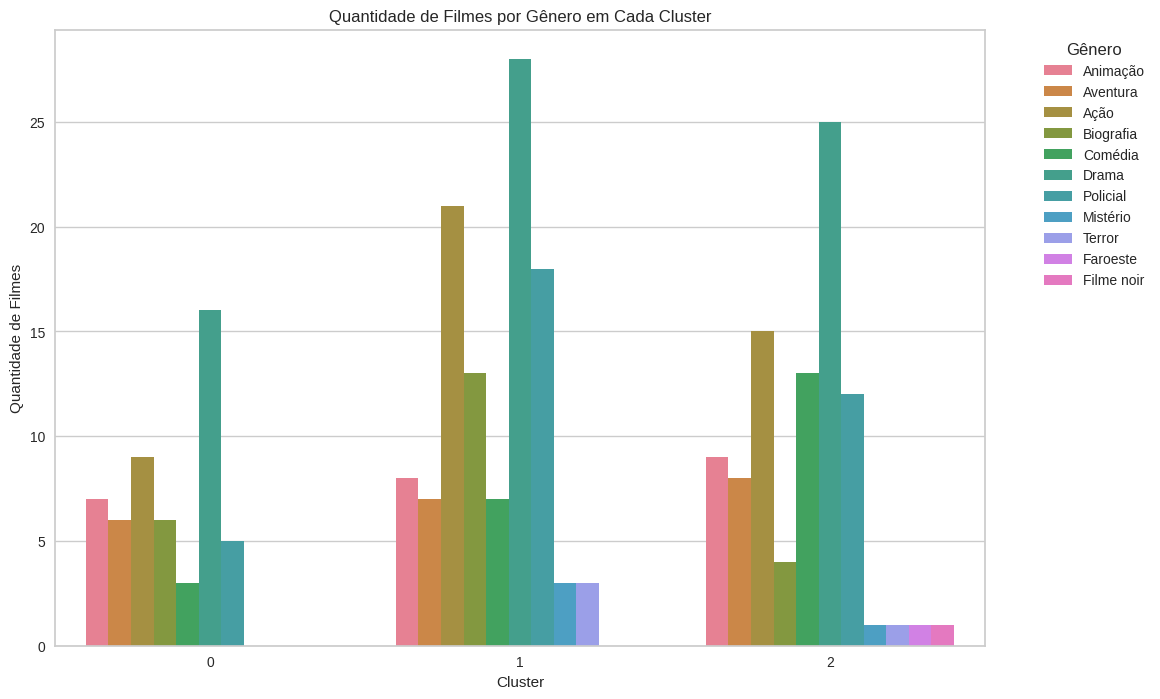

In [73]:
# Criando o gráfico de barras
plt.figure(figsize=(12,8))
sns.barplot(x='Cluster', y='count', hue='genre', data=cluster_genre_counts)
plt.title("Quantidade de Filmes por Gênero em Cada Cluster")
plt.xlabel("Cluster")
plt.ylabel("Quantidade de Filmes")
plt.legend(title="Gênero", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()